# First pass at 

In [17]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [41]:
def get_data(group, path):
    '''
    Creates a list of tuples, each with an image name and its bounding box statistics.
    Input: group - what picture group we want, path - path to text file.
    Output: list of tuples of data - data = (filename, bbs (list itself))
    '''

    # https: // towardsdatascience.com / how - do - you - train - a - face - detection - model - a60330f15fd5
    # path goes to the wider_faces_train_bbx_gt.txt

    f = open(path, 'r')
    file = f.readlines()
    data = []
    count = 0

    for i in file:
        # Grab the files for specific group
        if i[0:3] == "19-":
            # image name and remove \n
            filename = file[count]
            filename = filename[:-1]
            print(filename)

            # get bounding boxes
            numFaces = int(file[count + 1])
            bbsStart = count + 2
            print(bbsStart)
            boxes = []

            for j in range(0, numFaces):
                face = file[bbsStart + j]
                bbs = face.split(' ')
                bbs = bbs[:4]
                bbs = [int(k) for k in bbs]
                boxes.append(bbs)

            # Create a tuple with file name and list of bounding boxes, and save
            temp = (filename, boxes)
            data.append(temp)
        count += 1
    return data


In [99]:
def tester(data, prototxtPath, weightsPath):
    net = cv2.dnn.readNet(prototxtPath, weightsPath)
    total = []
    
    #For each image
    
    for i in range(0,len(data)):

        # load the input image from disk, clone it, and grab the image spatial dimensions
        image = cv2.imread(data[i][0], cv2.IMREAD_COLOR)
        (h, w) = image.shape[:2]

        # construct a blob from the image
        blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

        # pass the blob through the network and obtain the face detections
        net.setInput(blob)
        detections = net.forward()
        print(data[i])
        boxes = data[i][1]
        count = 0
        result = []
        
        # loop over the detections
        for j in range(0, detections.shape[2]):
            
            # extract the confidence (i.e., probability) associated with the detection
            confidence = detections[0, 0, j, 2]

            # filter out weak detections by ensuring the confidence is greater than the minimum confidence
            if confidence > 0.25:

                count += 1  # keep track of found faces

                # compute the (x, y)-coordinates of the bounding box for the object
                box = detections[0, 0, j, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # find closest match
                mindist = 9999999
                for k in range(0, len(boxes)):
                    x1 = boxes[k][0]
                    y1 = boxes[k][1]
                    dist = np.sqrt((x1 - startX) ** 2 + (y1 - startY) ** 2)
                    if dist < mindist:
                        mindist = dist
                        mink = k

                known = (boxes[mink][0], boxes[mink][1], boxes[mink][0] + boxes[mink][2], boxes[mink][1] + boxes[mink][3])
                found = (startX, startY, endX, endY)

                acc = get_iou(known, found)
                result.append(acc)

        # have count, result for the image
        print("Result: ", result)
        if result == []:
            result.append(0)
        out = (data[i][0], sum(result) / len(result), count)
        total.append(out)

    return total

In [100]:
def get_iou(bb1, bb2):
    """
    https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Or: bb1 is a tuple with data (x1, y1, x2, y2)
        bb2 is a tuple with data (x1, y1, x2, y2)

    Returns
    -------
    float
        in [0, 1]
    """
    # determine the coordinates of the intersection rectangle

    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [101]:
group = 'couples'
path = "/Users/thomcope/Documents/ACADEMICS/20 Fall/EECS504/wider_face_split/wider_face_train_bbx_gt.txt" #to text file
data = get_data(group, path)
prototxtPath = "/Users/thomcope/Documents/ACADEMICS/20 Fall/EECS504/deploy.prototxt"
weightsPath = "/Users/thomcope/Documents/ACADEMICS/20 Fall/EECS504/res10_300x300_ssd_iter_140000.caffemodel"

19--Couple/19_Couple_Couple_19_112.jpg
52144
19--Couple/19_Couple_Couple_19_671.jpg
52148
19--Couple/19_Couple_Couple_19_776.jpg
52152
19--Couple/19_Couple_Couple_19_124.jpg
52156
19--Couple/19_Couple_Couple_19_267.jpg
52159
19--Couple/19_Couple_Couple_19_7.jpg
52163
19--Couple/19_Couple_Couple_19_227.jpg
52167
19--Couple/19_Couple_Couple_19_212.jpg
52171
19--Couple/19_Couple_Couple_19_527.jpg
52175
19--Couple/19_Couple_Couple_19_324.jpg
52178
19--Couple/19_Couple_Couple_19_1011.jpg
52182
19--Couple/19_Couple_Couple_19_12.jpg
52192
19--Couple/19_Couple_Couple_19_924.jpg
52196
19--Couple/19_Couple_Couple_19_361.jpg
52200
19--Couple/19_Couple_Couple_19_165.jpg
52206
19--Couple/19_Couple_Couple_19_179.jpg
52210
19--Couple/19_Couple_Couple_19_1.jpg
52214
19--Couple/19_Couple_Couple_19_231.jpg
52218
19--Couple/19_Couple_Couple_19_363.jpg
52222
19--Couple/19_Couple_Couple_19_230.jpg
52226
19--Couple/19_Couple_Couple_19_773.jpg
52230
19--Couple/19_Couple_Couple_19_473.jpg
52245
19--Couple/19_

In [102]:
result = tester(data, prototxtPath, weightsPath)

('19--Couple/19_Couple_Couple_19_112.jpg', [[278, 178, 264, 376], [548, 262, 236, 348]])
Result:  [0.9534171502256609, 0.830146460537022]
('19--Couple/19_Couple_Couple_19_671.jpg', [[368, 307, 123, 144], [601, 187, 123, 150]])
Result:  [0.8014961261020572, 0.9252336448598131]
('19--Couple/19_Couple_Couple_19_776.jpg', [[494, 216, 101, 151], [385, 284, 118, 127]])
Result:  [0.7292636548423054]
('19--Couple/19_Couple_Couple_19_124.jpg', [[435, 384, 120, 219]])
Result:  [0.6853387576279143]
('19--Couple/19_Couple_Couple_19_267.jpg', [[594, 216, 162, 250], [340, 192, 182, 266]])
Result:  [0.8164932076009694, 0.9220632681845657, 0.38705620803485213]
('19--Couple/19_Couple_Couple_19_7.jpg', [[6, 8, 464, 666], [448, 4, 542, 670]])
Result:  [0.9241092581282164, 0.8903253577153714, 0.052412592414479514, 0.19985769928940864]
('19--Couple/19_Couple_Couple_19_227.jpg', [[578, 56, 196, 224], [238, 306, 164, 170]])
Result:  [0.7881741982507289, 0.939896557874086]
('19--Couple/19_Couple_Couple_19_212

('19--Couple/19_Couple_Couple_19_45.jpg', [[136, 316, 302, 332], [572, 220, 222, 308]])
Result:  [0.9298233285077795, 0.8259474595057071]
('19--Couple/19_Couple_Couple_19_457.jpg', [[278, 10, 226, 356], [504, 10, 310, 276]])
Result:  [0.9017297598700559, 0.6962098377477073]
('19--Couple/19_Couple_Couple_19_39.jpg', [[618, 266, 78, 102], [716, 204, 94, 130]])
Result:  [0.8887874638673361, 0.7415364583333334]
('19--Couple/19_Couple_Couple_19_841.jpg', [[316, 138, 56, 88], [366, 136, 60, 96]])
Result:  [0.6469194312796208, 0.7163995067817509]
('19--Couple/19_Couple_Couple_19_81.jpg', [[472, 107, 20, 62]])
Result:  []
('19--Couple/19_Couple_Couple_19_940.jpg', [[444, 165, 318, 499]])
Result:  [0.9509465634617178]
('19--Couple/19_Couple_Couple_19_853.jpg', [[350, 137, 90, 145], [275, 145, 75, 147]])
Result:  [0.8505119453924914]
('19--Couple/19_Couple_Couple_19_309.jpg', [[414, 209, 28, 48], [512, 222, 34, 39], [977, 321, 10, 14], [946, 269, 7, 11], [915, 328, 9, 12], [924, 277, 10, 13], [7

('19--Couple/19_Couple_Couple_19_173.jpg', [[436, 196, 414, 352], [58, 14, 356, 336], [404, 612, 322, 277]])
Result:  [0.7446014607812004, 0.8454189686924494]
('19--Couple/19_Couple_Couple_19_163.jpg', [[320, 76, 110, 98], [300, 130, 80, 104]])
Result:  []
('19--Couple/19_Couple_Couple_19_424.jpg', [[346, 242, 222, 348], [562, 226, 210, 352], [608, 44, 84, 118]])
Result:  [0.9680801850424056, 0.8515323912644522, 0.8968979469503972]
('19--Couple/19_Couple_Couple_19_340.jpg', [[586, 73, 160, 244], [389, 232, 189, 165]])
Result:  [0.8430038682139522, 0.7594268476621417]
('19--Couple/19_Couple_Couple_19_563.jpg', [[77, 393, 119, 109], [186, 42, 99, 121]])
Result:  [0.33685121107266436]
('19--Couple/19_Couple_Couple_19_238.jpg', [[254, 172, 144, 206], [404, 158, 108, 178]])
Result:  [0.8411501162592866, 0.6924157303370787]
('19--Couple/19_Couple_Couple_19_123.jpg', [[530, 270, 112, 174], [638, 210, 152, 174]])
Result:  [0.8198676933087518, 0.8644240570846076]
('19--Couple/19_Couple_Couple_1

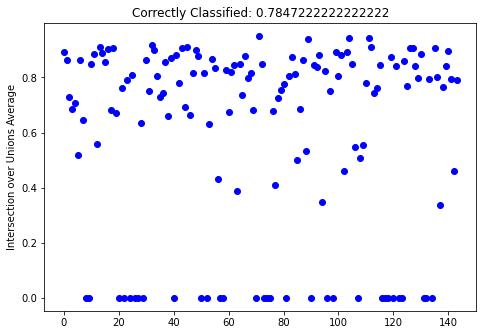

In [107]:
# for i in range(0, len(result)):
 
avg_acc = [result[i][1] for i in range(0,len(result))]
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(range(0,len(avg_acc)), avg_acc, color='b')
acc = np.count_nonzero(avg_acc)/len(avg_acc)
ax.set_title('Correctly Classified: {}'.format(acc))
ax.set_ylabel('Intersection over Unions Average')
plt.show()

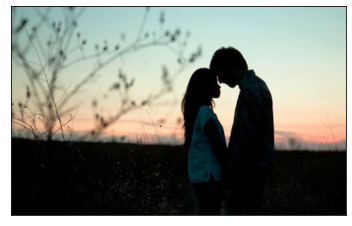

In [108]:
image = cv2.imread('19--Couple/19_Couple_Couple_19_133.jpg',cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()